# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl

%jsroot on
# %matplotlib qt
%matplotlib inline

In [2]:
from filterMethods import *
from reconstructionMethods import *
from statisticsMethods import *

In [3]:
sys.path.append("../")
import plotParameters

# Load Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [4]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration.root'
# file_input_name = '../runs/calibration_8x8x8_e-_5MeV/calibration.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
# file_input_name = '../build/event.root'
file_input_name = '../build/output.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [5]:
tree = file_input_uproot['photoSensor_hits;1']
data = {
    'position_initial': list(zip(
        tree['photoSensor_hits_position_initial_x'].array(),
        tree['photoSensor_hits_position_initial_y'].array(),
        tree['photoSensor_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['photoSensor_hits_position_absolute_x'].array(),
        tree['photoSensor_hits_position_absolute_y'].array(),
        tree['photoSensor_hits_position_absolute_z'].array()
    )),
    'process': tree['photoSensor_hits_process'].array()
}

df_photoSensor_hits = pd.DataFrame(data)

df_photoSensor_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_photoSensor_hits['position_initial'], df_photoSensor_hits['position_absolute'])]
df_photoSensor_hits['position_delta_r'] = np.linalg.norm(np.array(df_photoSensor_hits['position_delta'].tolist()), axis=1)

In [6]:
tree = file_input_uproot['calorimeter_hits;1']
data_calorimeter = {
    'position_initial': list(zip(
        tree['calorimeter_hits_position_initial_x'].array(),
        tree['calorimeter_hits_position_initial_y'].array(),
        tree['calorimeter_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['calorimeter_hits_position_absolute_x'].array(),
        tree['calorimeter_hits_position_absolute_y'].array(),
        tree['calorimeter_hits_position_absolute_z'].array()
    )),
    'process': tree['calorimeter_hits_process'].array()
}

df_calorimeter_hits = pd.DataFrame(data_calorimeter)

df_calorimeter_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_calorimeter_hits['position_initial'], df_calorimeter_hits['position_absolute'])]
df_calorimeter_hits['position_delta_r'] = np.linalg.norm(np.array(df_calorimeter_hits['position_delta'].tolist()), axis=1)

In [7]:
tree = file_input_uproot['lens_hits;1']
data_lens = {
    'position_initial': list(zip(
        tree['lens_hits_position_initial_x'].array(),
        tree['lens_hits_position_initial_y'].array(),
        tree['lens_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['lens_hits_position_absolute_x'].array(),
        tree['lens_hits_position_absolute_y'].array(),
        tree['lens_hits_position_absolute_z'].array()
    )),
    'process': tree['lens_hits_process'].array(),
    'transmittance': tree['lens_hits_transmittance'].array()
}

df_lens_hits = pd.DataFrame(data_lens)

df_lens_hits = df_lens_hits[df_lens_hits['transmittance'] != True]

df_lens_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_lens_hits['position_initial'], df_lens_hits['position_absolute'])]
df_lens_hits['position_delta_r'] = np.linalg.norm(np.array(df_lens_hits['position_delta'].tolist()), axis=1)

In [8]:
tree = file_input_uproot['photon;1']
data_photon = {
    'photon_stepNumber': tree['photon_stepNumber'].array(),
}

df_photon = pd.DataFrame(data_photon)

# Plot Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [9]:
nPhotons_total = np.sum(df_photon['photon_stepNumber'].values == 1)
nPhotons_calorimeter = len(df_calorimeter_hits)
nPhotons_photoSensor = len(df_photoSensor_hits)
nPhotons_medium = nPhotons_total - nPhotons_calorimeter - nPhotons_photoSensor

print("nPhotons_total      : ", nPhotons_total)
print("nPhotons_calorimeter: ", nPhotons_calorimeter)
print("nPhotons_photoSensor: ", nPhotons_photoSensor)

nPhotons_total      :  96112736
nPhotons_calorimeter:  6441653
nPhotons_photoSensor:  47770


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_10082/4173923343.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 500x500 with 0 Axes>

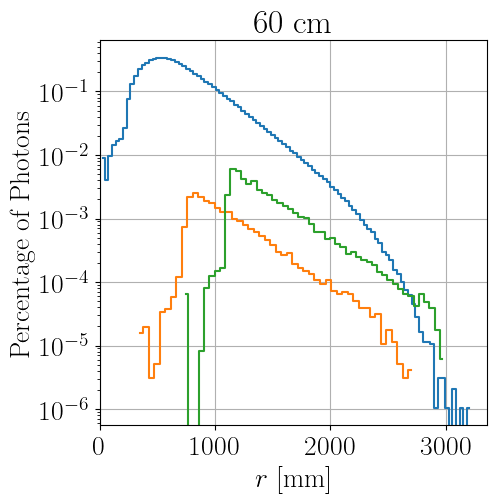

In [23]:
nBins = 50

PDF_photoSensor, hist_photoSensor, _, bins_photoSensor = get_PDF(df_photoSensor_hits['position_delta_r'], nBins=nBins)
PDF_calorimeter, hist_calorimeter, _, bins_calorimeter = get_PDF(df_calorimeter_hits['position_delta_r'], nBins=nBins)
PDF_lens       , hist_lens       , _, bins_lens        = get_PDF(df_lens_hits       ['position_delta_r'], nBins=nBins)

hist_scaled_photoSensor = hist_photoSensor / nPhotons_total * 100
hist_scaled_calorimeter = hist_calorimeter / nPhotons_total * 100
hist_scaled_lens        = hist_lens        / nPhotons_total * 100

bins_center_photoSensor = [(bins_photoSensor[i] + bins_photoSensor[i+1])/2 for i in range(len(bins_photoSensor)-1)]
bins_center_calorimeter = [(bins_calorimeter[i] + bins_calorimeter[i+1])/2 for i in range(len(bins_calorimeter)-1)]
bins_center_lens        = [(bins_lens       [i] + bins_lens       [i+1])/2 for i in range(len(bins_lens       )-1)]

fileName = '../figures/transmittance_60cm.pkl'
pkl_data = {
    'bins_center_photoSensor': bins_center_photoSensor,
    'bins_center_calorimeter': bins_center_calorimeter,
    'bins_center_lens'       : bins_center_lens,
    'hist_scaled_photoSensor': hist_scaled_photoSensor,
    'hist_scaled_calorimeter': hist_scaled_calorimeter,
    'hist_scaled_lens'       : hist_scaled_lens,
}
with open(fileName, 'wb') as f:
    pkl.dump(pkl_data, f)

pkl_data = pkl.load(open(fileName, 'rb'))
bins_center_photoSensor = pkl_data['bins_center_photoSensor']
bins_center_calorimeter = pkl_data['bins_center_calorimeter']
bins_center_lens        = pkl_data['bins_center_lens']
hist_scaled_photoSensor = pkl_data['hist_scaled_photoSensor']
hist_scaled_calorimeter = pkl_data['hist_scaled_calorimeter']
hist_scaled_lens        = pkl_data['hist_scaled_lens']

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bins_center_calorimeter, hist_scaled_calorimeter, label='calorimeter', drawstyle='steps-mid')
ax.plot(bins_center_lens       , hist_scaled_lens       , label='lens'       , drawstyle='steps-mid')
ax.plot(bins_center_photoSensor, hist_scaled_photoSensor, label='photosensor', drawstyle='steps-mid')
# ax.fill_between(bins_center_calorimeter, hist_scaled_calorimeter, 0, alpha=0.8)
# ax.fill_between(bins_center_lens       , hist_scaled_lens       , 0, alpha=0.8)
# ax.fill_between(bins_center_photoSensor, hist_scaled_photoSensor, 0, alpha=0.8)
ax.set_xlabel(r'$r$ [mm]')
ax.set_ylabel(r'Percentage of Photons')
ax.set_xlim(xmin=0)
# ax.set_ylim(ymin=0)
ax.set_yscale('log')
ax.set_title('60 cm')
# ax.legend(loc='upper right')
ax.grid()
# fig.savefig('../figures/transmittance_60cm_nolegend_v3.pdf', bbox_inches='tight')
fig.show()
